<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Predict-Coronavirus-COVID-19-trend/blob/master/Anomaly_detection_in_time_series_with_Prophet_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
from fbprophet import Prophet

!mkdir -p dataset
!wget -c -b http://www-personal.umich.edu/~mejn/cp/data/sunspots.txt -P dataset
data = np.loadtxt("dataset/sunspots.txt", float)

Continuing in background, pid 144.
Output will be written to ‘wget-log’.


In [3]:
# View the data as a table
data_as_frame = pd.DataFrame(data, columns=['Months', 'SunSpots'])
data_as_frame.tail(10)

,Months,SunSpots
3133,3133.0,18.8
3134,3134.0,15.4
3135,3135.0,8.0
3136,3136.0,8.7
3137,3137.0,13.6
3138,3138.0,16.1
3139,3139.0,19.6
3140,3140.0,25.2
3141,3141.0,23.5
3142,3142.0,21.6


In [4]:
data_as_frame['ds']=data_as_frame['Months'].astype(int)
data_as_frame.head()

,Months,SunSpots,ds
0,0.0,58.0,0
1,1.0,62.6,1
2,2.0,70.0,2
3,3.0,55.7,3
4,4.0,85.0,4


In [0]:
data_as_frame['time_stamp']=data_as_frame.apply(lambda x:(pd.Timestamp('1749-01-01')+pd.DateOffset(months = int(x['ds']))),axis=1)

#Cleaning the df, we only need two columns date time and the data
clean_df=data_as_frame.drop(['Months','ds'],axis=1)

clean_df.head()

## Prophet requires two columns, one is ds (the date time) and y (variable to be forecasted)
clean_df.columns = ['y', 'ds']

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Displaying Prophet plot


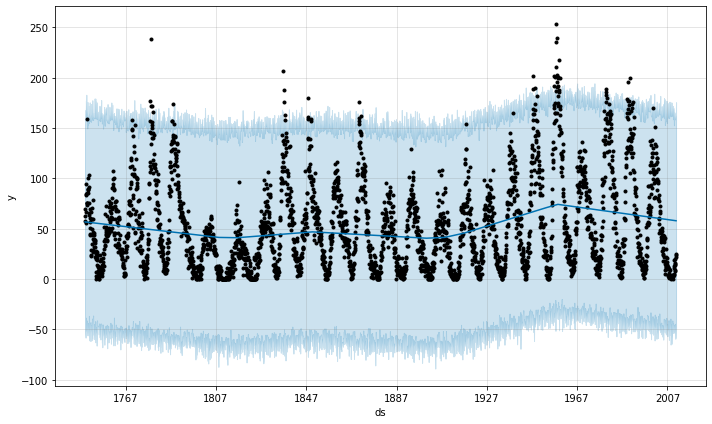

In [7]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(clean_df)

In [9]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,1749-01-01,56.852834,56.852834,-54.652411,152.583005,58.0,0,0.0
1,1749-02-01,56.830622,56.830622,-56.595201,160.674145,62.6,0,0.0
2,1749-03-01,56.810559,56.810559,-49.543273,157.641386,70.0,0,0.0
3,1749-04-01,56.788347,56.788347,-58.116404,168.146502,55.7,0,0.0
4,1749-05-01,56.766851,56.766851,-38.258136,159.149625,85.0,0,0.0


In [12]:
import altair as alt
alt.renderers.enable('notebook')
print(os.listdir("../input"))
from IPython.display import HTML

from  altair.vega import v3
import json
from IPython.display import HTML

def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sunspots'),    
        tooltip=['yearmonthdate(ds)', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()
    return render(alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20))
              
plot_anomalies(pred)

ValueError: ignored